In [1]:
import re
import json
import math
from dataclasses import dataclass
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
os.environ["DISABLE_MODEL_SOURCE_CHECK"] = "True"  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from paddleocr import PaddleOCR

Checking connectivity to the model hosters, this may take a while. To bypass this check, set `DISABLE_MODEL_SOURCE_CHECK` to `True`.


In [2]:
def show(img, title=None, cmap=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def to_bgr(pil_img: Image.Image) -> np.ndarray:
    arr = np.array(pil_img)
    if arr.ndim == 2:
        return cv2.cvtColor(arr, cv2.COLOR_GRAY2BGR)
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

def safe_float(x, default=0.0):
    try:
        return float(x)
    except Exception:
        return default


In [3]:
# Create ONE global model (no repeated "Creating model..." every call)
PADDLE_OCR = PaddleOCR(use_textline_orientation=True, lang="en")
print("✅ PaddleOCR initialized once.")


c:\Users\darvish\AppData\Local\Programs\Python\Python312\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\darvish\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('P

✅ PaddleOCR initialized once.


Loaded: D:\Arvand\uk\samples2\IMG_20251212_152936.jpg
Size: (720, 480) Mode: RGB


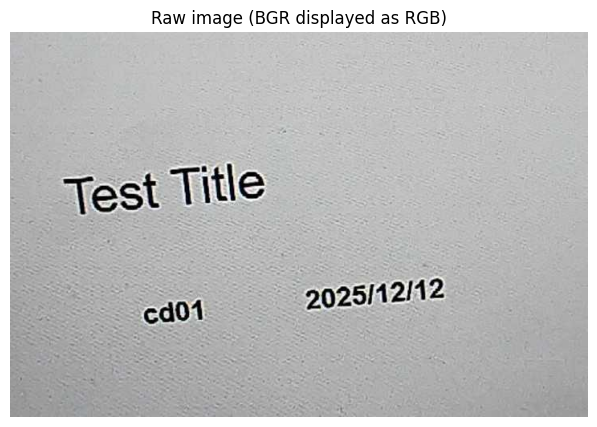

In [5]:
IMAGE_PATH = "D:\\Arvand\\uk\\samples2\\IMG_20251212_152936.jpg"  # put your path here

pil = Image.open(IMAGE_PATH)
bgr = to_bgr(pil)

print("Loaded:", IMAGE_PATH)
print("Size:", pil.size, "Mode:", pil.mode)

show(bgr, "Raw image (BGR displayed as RGB)")


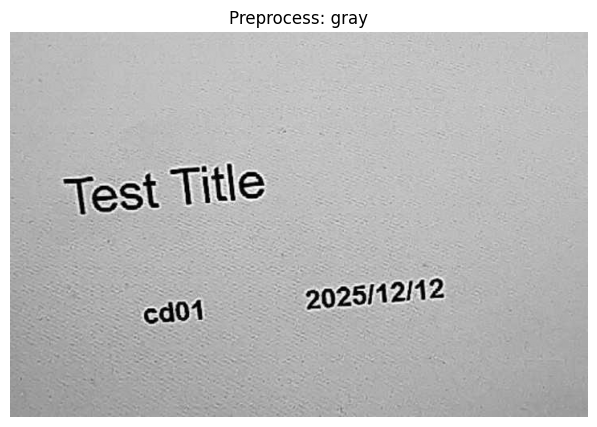

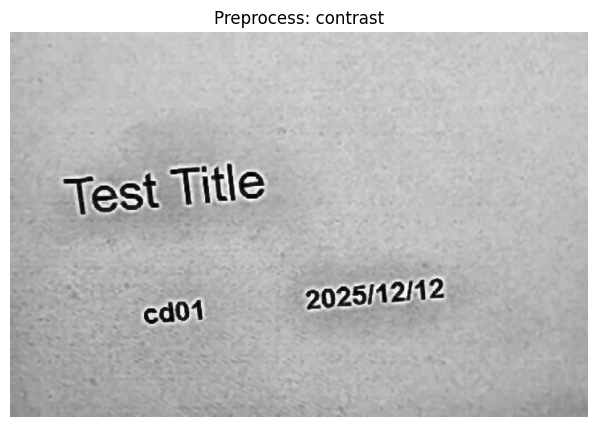

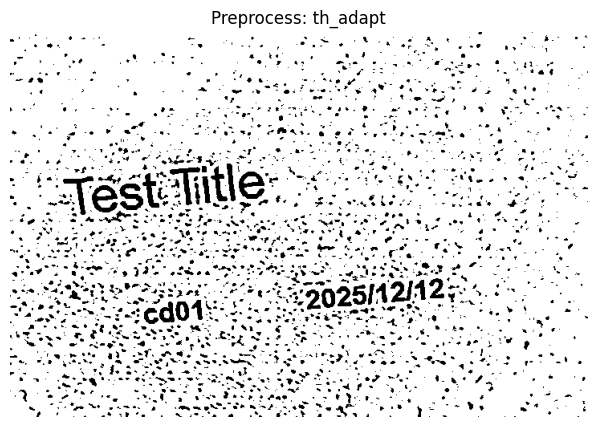

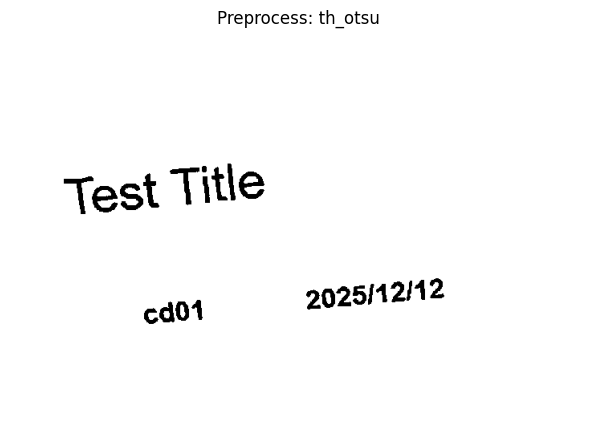

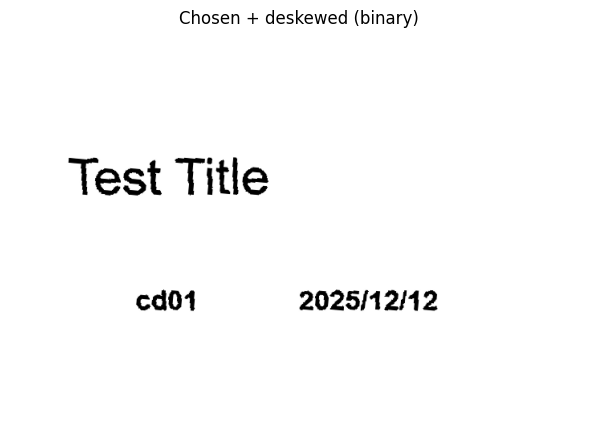

In [6]:
def preprocess_variants(bgr: np.ndarray) -> Dict[str, np.ndarray]:
    """Return multiple preprocessed images to compare."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Mild denoise
    den = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)

    # Contrast boost (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    con = clahe.apply(den)

    # Adaptive threshold (good for uneven lighting)
    th_adapt = cv2.adaptiveThreshold(
        con, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 7
    )

    # Otsu threshold (sometimes works great for clean scans)
    _, th_otsu = cv2.threshold(con, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return {
        "gray": gray,
        "contrast": con,
        "th_adapt": th_adapt,
        "th_otsu": th_otsu,
    }

def deskew(binary_img: np.ndarray) -> np.ndarray:
    """
    Deskew a binary image (white background, dark text).
    Returns rotated binary. Safe if it can't detect angle.
    """
    # Invert so text is white on black for easier nonzero extraction
    inv = 255 - binary_img
    coords = np.column_stack(np.where(inv > 0))
    if len(coords) < 50:
        return binary_img  # too little text to estimate

    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    # minAreaRect angle quirks:
    # angle in [-90, 0); convert to a more intuitive rotation
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = binary_img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(binary_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

variants = preprocess_variants(bgr)

for k, img in variants.items():
    show(img, f"Preprocess: {k}")

# Pick one thresholding result for OCR:
chosen = variants["th_otsu"]  # try th_otsu if better
deskewed = deskew(chosen)

show(deskewed, "Chosen + deskewed (binary)")
